In [1]:
import json
import numpy as np
import tensorflow.keras as keras
import music21 as m21
%run data_preprocessing.ipynb import SEQUENCE_LENGTH, MAPPING_PATH

Loading songs...
Loaded 1700 songs.
Song 0 out of 1700 processed
Song 10 out of 1700 processed


C:\Users\kurle\anaconda3\Lib\site-packages\music21\stream\base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


Song 20 out of 1700 processed
Song 30 out of 1700 processed
Song 40 out of 1700 processed
Song 50 out of 1700 processed
Song 60 out of 1700 processed
Song 70 out of 1700 processed
Song 80 out of 1700 processed
Song 90 out of 1700 processed
Song 100 out of 1700 processed
Song 110 out of 1700 processed
Song 120 out of 1700 processed
Song 130 out of 1700 processed
Song 140 out of 1700 processed
Song 150 out of 1700 processed
Song 160 out of 1700 processed
Song 170 out of 1700 processed
Song 180 out of 1700 processed
Song 190 out of 1700 processed
Song 200 out of 1700 processed
Song 210 out of 1700 processed
Song 220 out of 1700 processed
Song 230 out of 1700 processed
Song 240 out of 1700 processed
Song 250 out of 1700 processed
Song 260 out of 1700 processed
Song 270 out of 1700 processed
Song 280 out of 1700 processed
Song 290 out of 1700 processed
Song 300 out of 1700 processed
Song 310 out of 1700 processed
Song 320 out of 1700 processed
Song 330 out of 1700 processed
Song 340 out of 

In [2]:
class MelodyGenerator:
    """A class that wraps the LSTM model and offers utilities to generate melodies."""

    def __init__(self, model_path="model.h5"):
        """Constructor that initialises TensorFlow model"""

        self.model_path = model_path
        self.model = keras.models.load_model(model_path)

        with open(MAPPING_PATH, "r") as fp:
            self._mappings = json.load(fp)

        self._start_symbols = ["/"] * SEQUENCE_LENGTH


    def generate_melody(self, seed, num_steps, max_sequence_length, temperature):
        # create seed with start symbols
        seed = seed.split()
        melody = seed
        seed = self._start_symbols + seed

        # map seed to int
        seed = [self._mappings[symbol] for symbol in seed]

        for _ in range(num_steps):

            # limit the seed to max_sequence_length
            seed = seed[-max_sequence_length:]

            # one-hot encode the seed
            onehot_seed = keras.utils.to_categorical(seed, num_classes=len(self._mappings))
            # (1, max_sequence_length, num of symbols in the vocabulary)
            onehot_seed = onehot_seed[np.newaxis, ...]

            # make a prediction
            probabilities = self.model.predict(onehot_seed)[0]
            # [0.1, 0.2, 0.1, 0.6] -> 1
            output_int = self._sample_with_temperature(probabilities, temperature)

            # update seed
            seed.append(output_int)

            # map int to our encoding
            output_symbol = [k for k, v in self._mappings.items() if v == output_int][0]

            # check whether we're at the end of a melody
            if output_symbol == "/":
                break

            # update melody
            melody.append(output_symbol)

        return melody


    def _sample_with_temperature(self, probabilites, temperature):
        predictions = np.log(probabilites) / temperature
        probabilites = np.exp(predictions) / np.sum(np.exp(predictions))

        choices = range(len(probabilites)) # [0, 1, 2, 3]
        index = np.random.choice(choices, p=probabilites)

        return index
    def save_melody(self, melody, step_duration=1, format="midi", file_name="mel.mid"):

        # create a music21 stream
        stream = m21.stream.Stream()

        start_symbol = None
        step_counter = 1

        # parse all the symbols in the melody and create note/rest objects
        for i, symbol in enumerate(melody):

            # handle case in which we have a note/rest
            if symbol != "_" or i + 1 == len(melody):

                # ensure we're dealing with note/rest beyond the first one
                if start_symbol is not None:

                    quarter_length_duration = step_duration * step_counter # 0.25 * 4 = 1

                    
                    if start_symbol == "r":
                        m21_event = m21.note.Rest(quarterLength=quarter_length_duration)

                    
                    else:
                        m21_event = m21.note.Note(int(start_symbol), quarterLength=quarter_length_duration)

                    stream.append(m21_event)

                    
                    step_counter = 1

                start_symbol = symbol

          
            else:
                step_counter += 1

        
        stream.write(format, file_name)


In [3]:
if __name__ == "__main__":
    mg = MelodyGenerator()
    seed = "67 _ 67 _ 67 _ _ 65 67 _ 62 _ 63 _ _"
    seed2 = "67 _ _ _ _ _ 65 _ 62 _ 62 _ 60 _ _ _"
    melody = mg.generate_melody(seed, 500, SEQUENCE_LENGTH, 0.8)
    print(melody)
    mg.save_melody(melody)

1/1 [==============================] - ETA: 0s

C:\Users\kurle\AppData\Local\Temp\ipykernel_21580\2820505038.py:57: RuntimeWarning: divide by zero encountered in log
  predictions = np.log(probabilites) / temperature


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step
['67', '_', '67', '_', '67', '_', '_', '65', '67', '_', '62', '_', '63', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '77', '_', '_', '_', 'r', '68', '_', '_', '_', '_', 'r', '_', '74', '68', 'r', '68', '74', '68', 'r', '68', '59', '68', '59', '68', '59', '68', '59', '68', 'r', '68', '68', '68', '57', '68', '74', '68', '69', '68', '69', '68', '74', '68', '68', '74', '53', '68', '53', '68', '74', '68', '59', '68', 'r', '68', '68', '68', '57', '68', '74', '68', '62', '68', '68', '68', 'r', '68', '74', '68', '53', '68', '74', '68', '59', '68', 'r', '68', '51', '68', '68', '68', '57', '68', '74', '68', '53', '68', '59', '68', '59', '68', '53', '68', '53', '68', '74', '68', '74', '68', 'r', '68', 'r', '68', '68', '68', '57', '68

PermissionError: [Errno 13] Permission denied: 'mel.mid'

In [1]:
pip install pyFluidSynth

Note: you may need to restart the kernel to use updated packages.


In [2]:
import mido
import pretty_midi
import librosa
import librosa.display
import matplotlib.pyplot as plt

def midi_to_audio(midi_path, output_path):
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    audio_data = midi_data.fluidsynth()
    pretty_midi.audio.write_audio(output_path, audio_data, midi_data.sample_rate)

def generate_spectrogram(audio_path):
    # Load audio file using librosa
    y, sr = librosa.load(audio_path)

    # Generate spectrogram using librosa
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

    # Plot the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()

# Example usage
midi_file_path = 'mel.mid'
audio_file_path = 'mel.wav'

# Convert MIDI to audio
midi_to_audio(midi_file_path, audio_file_path)

# Generate and plot the spectrogram
generate_spectrogram(audio_file_path)


ImportError: fluidsynth() was called but pyfluidsynth is not installed.

In [3]:
pip show pyfluidsynth


Name: pyFluidSynth
Version: 1.3.2
Summary: Python bindings for FluidSynth, a MIDI synthesizer that uses SoundFont instruments
Home-page: https://github.com/nwhitehead/pyfluidsynth
Author: Nathan Whitehead
Author-email: nwhitehe@gmail.com
License: 
Location: C:\Users\kurle\anaconda3\Lib\site-packages
Requires: numpy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [5]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Specify the path to your WAV file
wav_file_path = 'C:\Users\kurle\Desktop\Song-generation-using-RNN\mel.wav'

# Load the audio file using librosa
y, sr = librosa.load(wav_file_path)

# Generate the spectrogram using librosa
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (1206080352.py, line 6)

C:\Users\kurle\AppData\Local\Temp\ipykernel_28140\4085471039.py:13: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


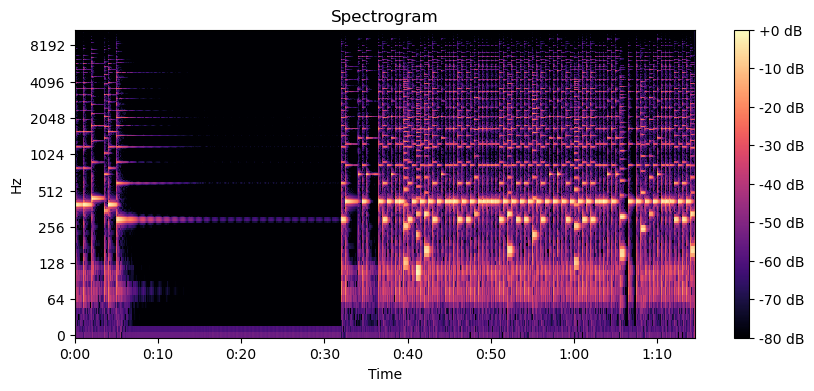

In [7]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np  # Add this line to import NumPy

# Specify the path to your WAV file using a raw string (prefix 'r')
wav_file_path = r'C:\Users\kurle\Desktop\Song-generation-using-RNN\mel.wav'

# Load the audio file using librosa
y, sr = librosa.load(wav_file_path)

# Generate the spectrogram using librosa
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()
